The S414 is a slotted, natural-laminar-flow airfoil. It is designed to have a laminar bucket between CL=.1 and CL=.65, but also have the ability to achieve high angles of attack and lift coefficients[1]. Below, the windtunnel results and the CFD results from the literature are compared to the results predicted by viiflow.
For OVERFLOW, the transition model in [2] was used.

**Important:** The use of this airfoil is restricted [3]. The geometry of the geometry used here is *not* the geometry used in the other CFD analysis methods nor in the wind tunnel experiments. It has been digitzed and smoothed, with permission, from the reference.
As such, this is not a thorough comparison of CFD results and wind tunnel data, but merely an example of Multi-Element airfoil analysis. The good match should therefore be taken with a tbsp. of salt.

All CFD methods use a transition model, and all are able to predict the laminar bucket and show good agreement with the measurements. Viiflow does predict a stronger increase in drag below the laminar bucket compared to the other methods and the windtunnel results. All methods overpredict maximum lift, with viiflow and MSES closely agreeing on the lift slope, which is not surprising given their similar boundary layer formulation.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
interactive_plot = False
import numpy as np
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
if interactive_plot:
    %matplotlib notebook
    matplotlib.rcParams['figure.figsize'] = [10, 7] 
    lines = None
    fig, ax = plt.subplots(1,1)
else:
    %matplotlib inline
    matplotlib.rcParams['figure.figsize'] = [12, 6]
%config InlineBackend.figure_format = 'svg'

AL: -7.000000 CL: -0.406924 CD0: 0.011937 CD1: 0.003083
AL: -6.800000 CL: -0.382948 CD0: 0.011581 CD1: 0.003098
AL: -6.600000 CL: -0.358553 CD0: 0.011260 CD1: 0.003111
AL: -6.400000 CL: -0.333777 CD0: 0.010874 CD1: 0.003126
AL: -6.200000 CL: -0.307500 CD0: 0.010486 CD1: 0.003140
AL: -6.000000 CL: -0.281192 CD0: 0.010155 CD1: 0.003154
AL: -5.800000 CL: -0.255025 CD0: 0.009878 CD1: 0.003166
AL: -5.600000 CL: -0.228779 CD0: 0.009654 CD1: 0.003177
AL: -5.400000 CL: -0.201787 CD0: 0.009414 CD1: 0.003188
AL: -5.200000 CL: -0.174983 CD0: 0.009168 CD1: 0.003199
AL: -5.000000 CL: -0.148122 CD0: 0.008938 CD1: 0.003209
AL: -4.800000 CL: -0.121487 CD0: 0.008786 CD1: 0.003219
AL: -4.600000 CL: -0.094668 CD0: 0.008601 CD1: 0.003228
AL: -4.400000 CL: -0.067733 CD0: 0.008432 CD1: 0.003236
AL: -4.200000 CL: -0.040786 CD0: 0.008217 CD1: 0.003246
AL: -4.000000 CL: -0.013173 CD0: 0.007742 CD1: 0.003251
AL: -3.800000 CL: 0.015743 CD0: 0.005971 CD1: 0.003252
AL: -3.600000 CL: 0.033101 CD0: 0.004009 CD1: 0.0

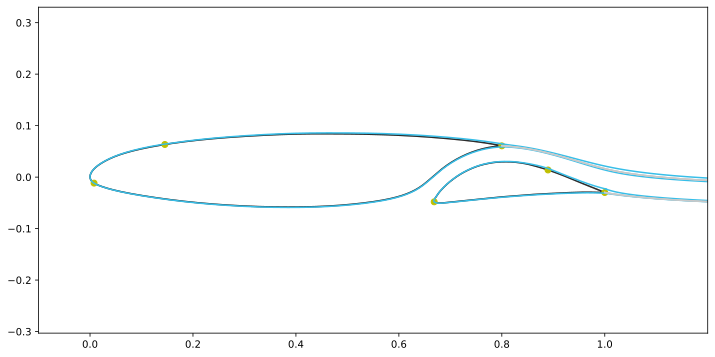

In [3]:
# Read and repanel airfoil data
BASE = vft.repanel(vft.read_selig("S414Main.dat")[:,::-1],190)
SLOT = vft.repanel(vft.read_selig("S414Aft.dat")[:,::-1],190)
# More refined in laminar bucket
AOARANGE = np.r_[np.arange(-7,5,0.2),np.arange(5,20.5,0.5)]
#AOARANGE = np.r_[np.arange(5,22,0.5)]

# Scale to c=1
SCALE = np.max(SLOT[0,:])
BASE = BASE/SCALE;
SLOT = SLOT/SCALE;

# Setup
RE = 1.0e6
ncrit = 9.0
Mach = 0.1
AOA0 = AOARANGE[0]
s = vf.setup(Re=RE,Ma=Mach,Ncrit=ncrit,Alpha=AOA0)
s.IterateWakes = False
s.Silent = True



# Set-up and initialize based on inviscid panel solution
(p,bl,x) = vf.init([BASE,SLOT],s)

# result array
alv = []
clv = []
cdv = []

lines = None # For plot function
if not interactive_plot:
    fig, ax = plt.subplots(1,1)
else:
    # For interactive plot. We iterate for 10 iterations and, if not converged, can observe the solution.
    s.Itermax = 10
for alpha in AOARANGE:
    s.Alpha = alpha
    res = None
    grad = None
    for k in range(int(100/s.Itermax)): # Make effectively 100 iterations, but show some in between
        [x,flag,res,grad,_] = vf.iter(x,bl,p,s,res,grad)
        
        # Plot geometry and update interactively
        if interactive_plot:
            nres=np.sqrt(np.dot(res.T,res))
            lines = vfp.plot_geometry(ax,p,bl,lines)
            title = "AOA %f RES %f"%(alpha,nres)
            ax.set_title(title)
            fig.canvas.draw()
        # Just plot a single geometry at AOA = 5°
        elif alpha==5:
            lines = vfp.plot_geometry(ax,p,bl,lines)

        # Decide whether to stop iterating
        if flag>0:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD+bl[1].CD)
            print('AL: %f CL: %f CD0: %f CD1: %f' % (alpha,clv[-1],bl[0].CD,bl[1].CD) ) 
            break
    if flag<=0:
        (p,bl,x) = vf.init([BASE,SLOT],s)


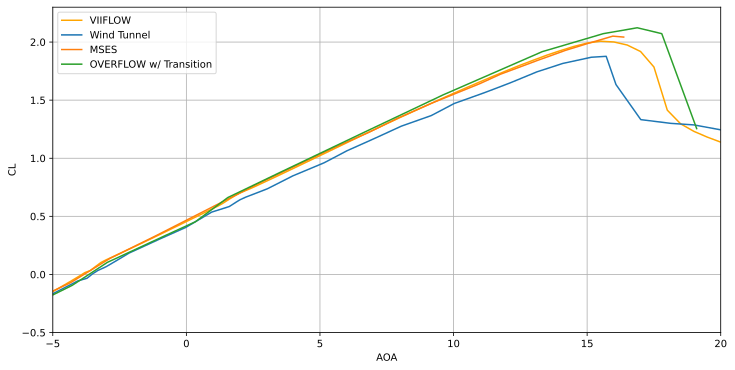

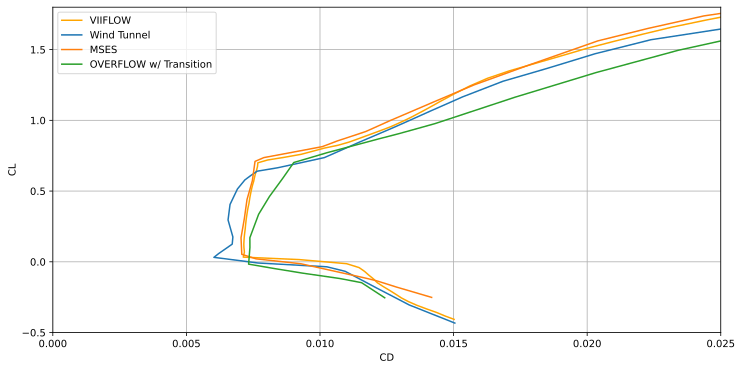

In [4]:
# Load airfoil measurement data
PolarMaughmerWT = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[0,1])
PolarMaughmerMSES = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[2,3])
PolarMaughmerOVERFLOW = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[4,5])
CLMaughmerWT = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[0,1])
CLMaughmerMSES = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[2,3])
CLMaughmerOVERFLOW = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[4,5])

# Make a new plot with the results
fig,ax = plt.subplots(1,1)
ax.plot(alv,clv,color="orange")
ax.plot(CLMaughmerWT.T[0],CLMaughmerWT.T[1])
ax.plot(CLMaughmerMSES.T[0],CLMaughmerMSES.T[1])
ax.plot(CLMaughmerOVERFLOW.T[0],CLMaughmerOVERFLOW.T[1])

ax.set_xlabel('AOA')
ax.set_ylabel('CL')
ax.legend(['VIIFLOW','Wind Tunnel','MSES','OVERFLOW w/ Transition'])
ax.grid(1)
ax.set_xlim([-5,20])
ax.set_ylim([-0.5,2.3])

fig,ax = plt.subplots(1,1)
ax.plot(cdv,clv,color="orange")
ax.plot(PolarMaughmerWT.T[0]/1000,PolarMaughmerWT.T[1])
ax.plot(PolarMaughmerMSES.T[0]/1000,PolarMaughmerMSES.T[1])
ax.plot(PolarMaughmerOVERFLOW.T[0]/1000,PolarMaughmerOVERFLOW.T[1])

ax.set_xlabel('CD')
ax.set_ylabel('CL');
ax.legend(['VIIFLOW','Wind Tunnel','MSES','OVERFLOW w/ Transition'])
ax.set_xlim([0,0.025])
ax.set_ylim([-0.5,1.8])
ax.grid(1)

[1] Mark D. Maughmer, James G. Coder, and Dan M. Somers, *Exploration of a Slotted, Natural-Laminar-Flow Airfoil Concept*, 2018 Applied Aerodynamics Conference. Atlanta, Georgia. 

[2] James G. Coder and Mark D. Maughmer, *Fluid Dynamics Compatible Transition Modeling Using an Amplification Factor Transport Equation*, AIAA Journal 2014 52:11, 2506-2512 

**[3] The original coordinates, and the concept of this airfoil, are patented under US Patent 6905092 B2.
To use this proprietary airfoil, a license agreement with *Airfoil, Incorporated* is necessary and its use is subject to distribution restrictions imposed by the U.S. Army.**